<a href="https://colab.research.google.com/github/gaioguy/EntropicTransferOperators/blob/main/Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entropic transfer operators
### Experiment 2: the Lorenz system
cf. [Junge, Matthes, Schmitzer: Entropic transfer operators](https://arxiv.org/abs/?)

## preparations

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pykeops[colab] > install.log
import sys
loc="/content/drive/MyDrive/LagrangianOT/"
sys.path.append(loc)
import numpy as np
import scipy
import scipy.sparse
import lib.SinkhornKeops as SinkhornKe
from lib.header_notebook import *
from scipy.sparse.linalg import eigs
from scipy.integrate import odeint
from ipywidgets import IntProgress
from IPython.display import display
%config InlineBackend.figure_format = 'retina'
    
def plotSpectrum(eigvals, markersize=10, axis=[-1.05, 1.05, -1.05, 1.05]):
    ax = plt.gca()
    ax.set_aspect('equal');
    cc = plt.Circle((0,0), 1, alpha=0.2)
    ax.add_artist(cc) 
    plt.scatter(eigvals.real,eigvals.imag, s=markersize)
    plt.axis(axis)
    return ax

Mounted at /content/drive
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


## the Lorenz system
as the approximating point cloud, we take an equi-spaced sampling of a trajectory

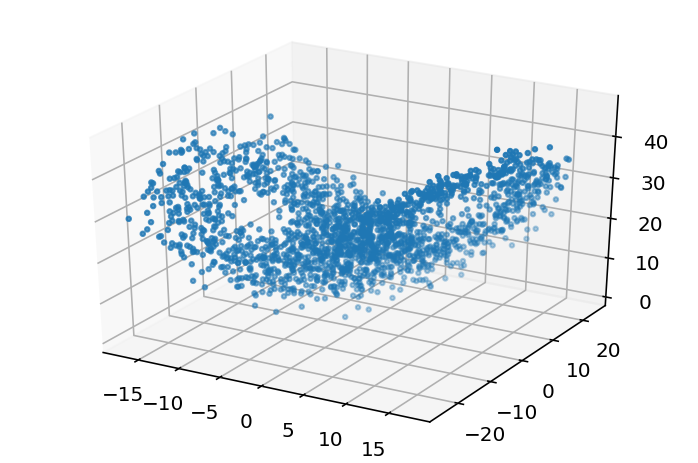

In [4]:
σ, β, ρ =  10., 8./3., 28.
def v(state, t):
    x, y, z = state  
    return [σ*(y-x), x*(ρ-z)-y, x*y-β*z]

n = 2000 # or 4000
x0, tf = [1.0, 1.0, 1.0], 810.0
t = np.arange(0.0, tf, 0.1)
sol = odeint(v, x0, t).astype(np.float32)

l = sol.shape[0]
δ = int((l-100)/n)
X = sol[range(100, l-1, δ), :]  # ignore the first 100 points
Y = sol[range(101, l, δ), :]
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,0], X[:,1], X[:,2], s=5)
#plt.savefig('lorenz_attractor.pdf')

## initialze the Keops Sinkhorn solver

In [6]:
xres, dim = X.shape
yres = Y.shape[0]
print(xres, yres, dim)

μX = np.ones(xres, dtype=np.float32)
μX = μX/np.sum(μX)
μY = np.ones(yres, dtype=np.float32)
μY = μY/np.sum(μY)

ε, errorGoal = 0.3, 1E-4
solver = SinkhornKe.TKeopsSinkhornSolverStandard(X, Y, μX, μY, errorGoal, eps=ε, epsInit=1.E0, verbose=False)
solver.solve()

2000 2000 3
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((Var(0,1,1)-Sum((Var(1,3,0)-Var(2,3,1))**2))+Var(3,1,1),1),0) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((Var(0,1,0)-Sum((Var(1,3,0)-Var(2,3,1))**2))+Var(3,1,0),1),1) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((((Var(0,1,0)+Var(1,1,1))-Sum((Var(2,3,0)-Var(3,3,1))**2))+Var(4,1,0))+Var(5,1,1),1),0) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((Var(0,1,1)-Sum((Var(1,3,0)-Var(2,3,1))**2))/Var(3,1,2)+Var(4,1,1),1),0) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((Var(0,1,0)-Sum((Var(1,3,0)-Var(2,3,1))**2))/Var(3,1,2)+Var(4,1,0),1),1) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat((((Var(0,1,0)+Var(1,1,1))-Sum((Var(2,3,0)-Var(3,3,1))**2))/Var(4,1,2)+Var(5,1,0))+Var(6,1,1),1),0) ... OK


0

## real spectrum of Γ close to 1 for some specific ε

[1.0000025 +0.j 0.96593446+0.j 0.9353922 +0.j 0.8194677 +0.j
 0.7141818 +0.j 0.6733599 +0.j]


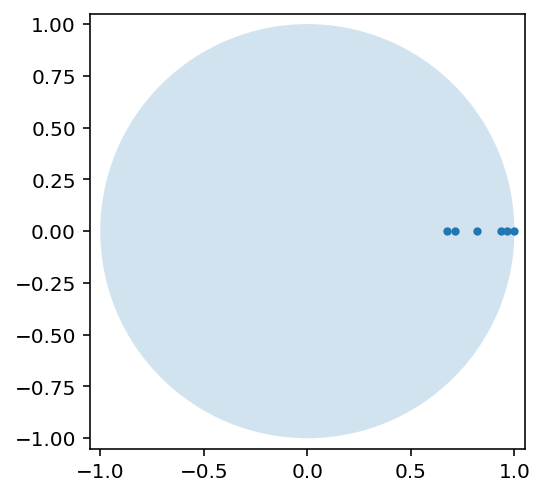

In [32]:
ε = 1
solver.setRelEpsList(ε)
solver.solve()
Γ = solver.extractCoupling(thresh=1E-16, maxLen=1E7)
Γ.data[:] *= xres
eigdat = eigs(Γ, k=30, which='LR')
K = np.logical_and(np.isreal(eigdat[0]), eigdat[0] > 0)
λ = eigdat[0][K]
plotSpectrum(λ)
print(λ)

# plot eigenvector

λ = 0.965934


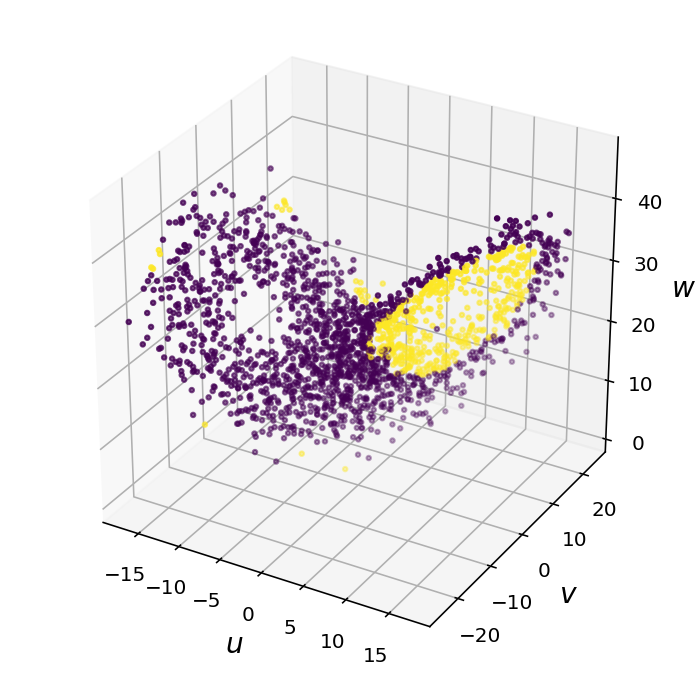

In [46]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
eigvecs = eigdat[1]
k = 1  # which eigenvector to plot
print('λ = ' + '%f' % eigdat[0][K][k].real)
c = eigvecs[:,k].real
ax.scatter(X[:,0], X[:,1], X[:,2], s=5, c=np.sign(c))

# ax.xaxis.set_major_locator(plt.MaxNLocator(3))
# ax.yaxis.set_major_locator(plt.MaxNLocator(3))
# ax.zaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xlabel(r'$u$', fontsize=14)
ax.set_ylabel(r'$v$', fontsize=14)
ax.set_zlabel(r'$w$', fontsize=14)
#plt.savefig(loc+"figures/lorenz-ev3_eps=1_n=4k.pdf")
plt.show()

## real spectra of Γ close to 1 in dependence of ε

In [47]:
ε0, ε1, nε, nσ = 1, -3, 200, 30           # ε range, no of εs, no of eigenvalues
εs = np.logspace(ε0, ε1, num = nε)
σs = np.zeros((nε, nσ))                   # spectra for different ε
progressbar = IntProgress(min=0, max=nε)
display(progressbar)

for k in np.arange(0, nε):
  solver.setRelEpsList(εs[k])
  solver.solve()
  Γ = solver.extractCoupling(thresh=1E-16,maxLen=1E7)
  Γ.data[:] *= xres
  eigdat = eigs(Γ, k=nσ, which='LR')
  I = np.logical_and(np.isreal(eigdat[0]), eigdat[0] > 0)
  λ = eigdat[0][I]
  σs[k,0:np.shape(λ)[0]] = λ.real
  progressbar.value += 1

filename = 'spectra_N='+'%d'%xres+'_eps='+'%1.0f'%ε0+'-to-'+'%1.0f'%ε1
np.savez(loc + 'dump/lorenz/' + filename, epsilons=εs, eigenvalues=σs)

IntProgress(value=0, max=200)

KeyboardInterrupt: ignored

## plot real spectra in dependence of ε

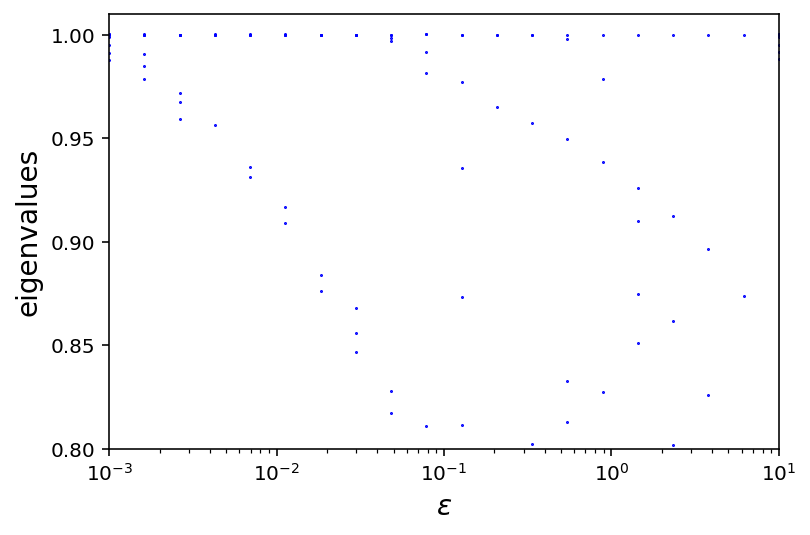

In [31]:
eigdat = np.load(loc + 'dump/lorenz/' + filename + '.npz')
εs, σs = eigdat['epsilons'], eigdat['eigenvalues']
plt.plot(εs, σs, '.', markersize=1, color='blue')

plt.axis([10**ε1, 10**ε0, 0.8, 1.01])
ax = plt.gca()
ax.set_xscale('log')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.xlabel(r"$\varepsilon$", fontsize=14)
plt.ylabel("eigenvalues", fontsize=14)
plt.savefig(loc + 'figures/lorenz/' + filename + '.pdf')